# Time Series Forecasting with *scikit-learn* 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Get the data 

In [14]:
df = pd.read_csv("./consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
grouped = df.groupby('location')
data = grouped.get_group('oslo')
target = data['consumption']
data.head()

,location,consumption,temperature
time,,,
2022-04-07 21:00:00,oslo,4.092830,1.0
2022-04-07 22:00:00,oslo,3.818095,0.4
2022-04-07 23:00:00,oslo,3.660981,0.3
2022-04-08 00:00:00,oslo,3.584066,0.2
2022-04-08 01:00:00,oslo,3.549536,0.4


So, your task is to forecast consumption values every day around 10 a.m. for the next day. For example, you have to forecast the 24 consumption values on September 18, 2023, at 10:00 for September 19, 2023, 00:00 to September 19, 2023, 23:00 (24 hours).
Beware that all the historical consumption data is not available at the time of forecasts. We only get access to data 5 days after. That means, when you are forecasting consumption for September 19th, you can only use historical consumption values till September 13, 2023. Except for the weather forecasts, they are available a day in advance, so feel free to use them in your models. With the same example as above, you can use the weather forecasts for 19th September, when you are forecasting consumption for 19th September.

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler_temp = MinMaxScaler()
scaler_cons = MinMaxScaler()

# initialize features df
features = data[['temperature', 'consumption']]

# Fit the scaler to the data and transform the specified column
features[['temperature']] = scaler_temp.fit_transform(features[['temperature']])
# fit to sin/cos stuff
features[['temperature']] = 2 * features[['temperature']] - 1
# consumption of last hour -> maybe not last hour to predict further in the future
features[['consumption']] = scaler_cons.fit_transform(features[['consumption']])
features[['consumption']] = 2 * features[['consumption']] - 1
features[['target']] = features[['consumption']]

features['day_mean'] = features[['consumption']].rolling(window=24).mean() # dayly mean

# include the last available consumption value from 5 days ago
features[['day_mean']] = features[['day_mean']].shift(120) # 120 = 5 days * 24 hours
features[['consumption']] = features[['consumption']].shift(168) # 120 = 5 days * 24 hours

# Cyclical Encoding for Periodic Features to learn hourly, weekly and yearly patterns
features['Hour_Sin'] = np.sin(2 * np.pi * features.index.hour / 24)
features['Hour_Cos'] = np.cos(2 * np.pi * features.index.hour / 24)
features['Day_Sin'] = np.sin(2 * np.pi * features.index.dayofweek / 7)
features['Day_Cos'] = np.sin(2 * np.pi * features.index.dayofweek / 7)
features['Week_Sin'] = np.sin(2 * np.pi * features.index.isocalendar().week / 52)
features['Week_Cos'] = np.sin(2 * np.pi * features.index.isocalendar().week / 52)

# shift 120 to get to the first values that have information from 5 days ago and 24 more to have the first valid dayly mean values
features = features.iloc[192:] 

features.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set 

,temperature,consumption,target,day_mean,Hour_Sin,Hour_Cos,Day_Sin,Day_Cos,Week_Sin,Week_Cos
time,,,,,,,,,,
2022-04-15 21:00:00,-0.053097,-0.708831,-0.840154,-0.785974,-0.707107,0.707107,-0.433884,-0.433884,0.970942,0.970942
2022-04-15 22:00:00,-0.075221,-0.725230,-0.855923,-0.788064,-0.500000,0.866025,-0.433884,-0.433884,0.970942,0.970942
2022-04-15 23:00:00,-0.115044,-0.736439,-0.864329,-0.790116,-0.258819,0.965926,-0.433884,-0.433884,0.970942,0.970942
2022-04-16 00:00:00,-0.141593,-0.753758,-0.872158,-0.791749,0.000000,1.000000,-0.974928,-0.974928,0.970942,0.970942
2022-04-16 01:00:00,-0.199115,-0.760658,-0.870717,-0.793046,0.258819,0.965926,-0.974928,-0.974928,0.970942,0.970942


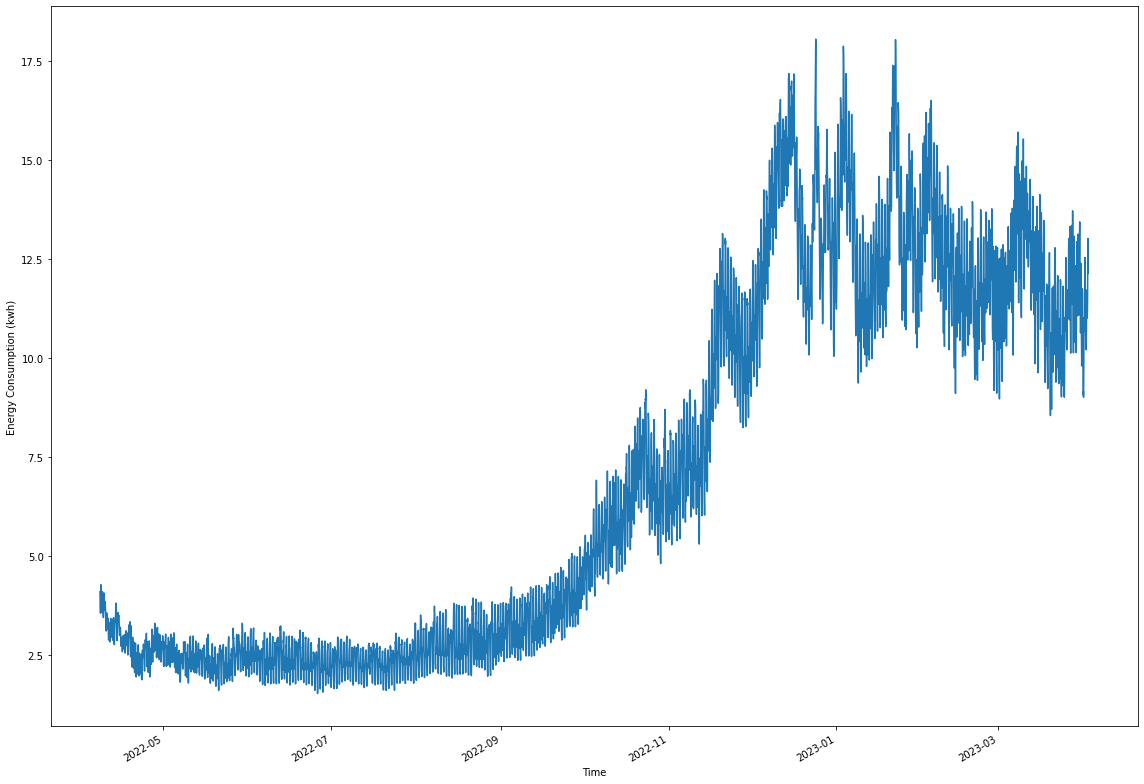

In [16]:
fig, ax = plt.subplots(figsize=(16, 11))

ax.plot(data['consumption'])
ax.set_xlabel('Time')
ax.set_ylabel('Energy Consumption (kwh)')

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
data = data.interpolate()
data.isnull().sum()

location       0
consumption    0
temperature    0
dtype: int64

## Predict the next step using the last observation 

In [17]:
df = features.copy()

In [18]:
from sklearn.model_selection import train_test_split

X = df[['temperature', 'consumption', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos', 'day_mean']].values
y = df[['target']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


### Baseline model: repeat the last observation 

### Apply a Decision Tree (can be replaced with any regressor model in sklearn) 

In [19]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X=X_train, y=y_train)

print(dt_reg.feature_importances_)

# Make predictions
dt_pred = dt_reg.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(y_test, dt_pred))

[1.89298291e-02 8.24237579e-01 8.50225300e-03 2.51087390e-03
 4.95548115e-04 1.07647220e-03 5.62084034e-02 1.32025982e-02
 7.48364428e-02]
0.08135605051066741


In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y=y_train.ravel())

print(gbr.feature_importances_)

gbr_pred = gbr.predict(X_test)

print(r2_score(y_test, gbr_pred))

[4.43474330e-02 8.53566196e-01 6.99369924e-03 2.15009411e-03
 3.51001091e-04 3.53488631e-04 1.57107616e-02 1.90657073e-02
 5.74616190e-02]
0.6370679660904521


### Baseline model: predict the mean 

## Predict a sequence 

In [31]:
def create_consumption_features(data, specified_day:str, scaler_cons:MinMaxScaler, scaler_temp:MinMaxScaler, location:str='oslo'):
    # Convert specified_day to a datetime object
    specified_day = pd.to_datetime(specified_day)
    
    # Create a DataFrame with a datetime index for the specified day and 24 rows
    date_rng = pd.date_range(start=specified_day, periods=24, freq='H')
    df1 = pd.DataFrame(index=date_rng)
    
    # Calculate the datetime 120 hours before the specified day
    reference_time = specified_day - pd.DateOffset(hours=120)
    reference_time2 = specified_day - pd.DateOffset(hours=168)

    cons_data_week = data.loc[reference_time2:reference_time2+pd.DateOffset(hours=23), ['consumption']]
    
    # Find corresponding values in additional_df for the reference time
    cons_data = data.loc[reference_time-pd.DateOffset(hours=24):reference_time+pd.DateOffset(hours=23), ['consumption']]
    temp_data = data.loc[date_rng, ['temperature']]

    cons_data['consumption'] = scaler_cons.transform(cons_data)
    cons_data = 2 * cons_data - 1
    cons_data_week['consumption'] = scaler_cons.transform(cons_data_week)
    cons_data_week = 2 * cons_data_week - 1
    temp_data['temperature'] = scaler_temp.transform(temp_data)
    temp_data = 2 * temp_data - 1

    cons_data['day_mean'] = cons_data.rolling(window=24).mean()
    cons_data = cons_data.iloc[-24:]
    cons_data = cons_data.drop('consumption', axis=1)

    cons_data.reset_index(drop=True, inplace=True)
    temp_data.reset_index(drop=True, inplace=True)
    cons_data_week.reset_index(drop=True, inplace=True)

    df = pd.concat([cons_data, temp_data, cons_data_week], axis=1) 
    df.index = df1.index

    df['Hour_Sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['Hour_Cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['Day_Sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['Day_Cos'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['Week_Sin'] = np.sin(2 * np.pi * df.index.isocalendar().week / 52)
    df['Week_Cos'] = np.sin(2 * np.pi * df.index.isocalendar().week / 52)

    X = df[['temperature', 'consumption', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Week_Sin', 'Week_Cos', 'day_mean']].values
    
    return X

In [32]:
specified_day = '2022-10-08'
X = create_consumption_features(data, specified_day, scaler_cons, scaler_temp)
gbr_pred = gbr.predict(X)
gbr_pred = np.add(gbr_pred, 1)
gbr_pred = np.divide(gbr_pred, 2)
gbr_pred = gbr_pred.reshape(-1, 1)
gbr_pred = scaler_cons.inverse_transform(gbr_pred)
print(gbr_pred)

[[ 9.63659359]
 [ 9.71769757]
 [ 9.68328761]
 [ 9.64186028]
 [ 9.68043876]
 [ 9.70949515]
 [10.34613261]
 [10.65342355]
 [11.3153933 ]
 [11.43705049]
 [11.10667664]
 [11.22312925]
 [10.54249167]
 [10.52589065]
 [10.83415409]
 [11.43867989]
 [12.09041287]
 [12.41984423]
 [12.92927421]
 [12.95825425]
 [12.31553751]
 [12.49376032]
 [11.89345334]
 [11.08417422]]


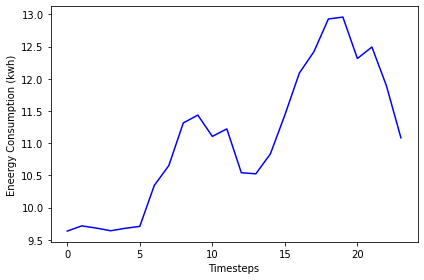

In [33]:
fig, ax = plt.subplots()

ax.plot(gbr_pred, 'b-')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Eneergy Consumption (kwh)')

# fig.autofmt_xdate()
plt.tight_layout()

### Apply a decision tree 

### Apply gradient boosting 

In [34]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)
print(r2_score(y_test, gbr_seq_preds))

0.6370679660904521


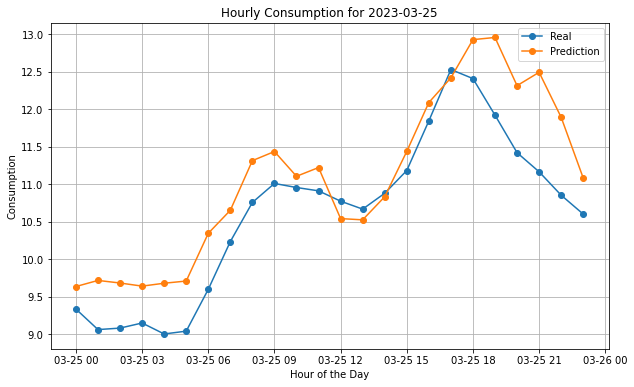

In [37]:
# Extract data for the specified day
day_data = data[data.index.strftime('%Y-%m-%d') == specified_day]

# Create a Matplotlib plot
plt.figure(figsize=(10, 6))
plt.plot(day_data.index, day_data['consumption'], label='Real', marker='o', linestyle='-')
plt.plot(day_data.index, gbr_pred, label='Prediction', marker='o', linestyle='-')
plt.xlabel('Hour of the Day')
plt.ylabel('Consumption')
plt.title(f'Hourly Consumption for {specified_day}')
plt.grid(True)
plt.legend()
plt.show()